## Dam modelling

The paper of Norooz et al. (2021) describes synthetic modellings and inversions of data from an embankment dam based on the following sketch:

![DamSketch](sketch.png)

It consists of an inner core (A), an outer core of two materials (B+C), and a main body D.
On the upstream side (U.S.) there is a water table, on the downstream side (N.S.) not.
Due to the water, the properties of the regions B+C+D will be different on US from NS and depend on the water table.
We demonstrate hot to build this model from the scratch using the pyGIMLi meshtools.

Norooz, R., Olsson, P.-I., Dahlin, T., Günther, T. & Bernstone, C. (2021): A geoelectrical pre-study of Älvkarleby test embankment dam: 3D forward modelling and effects of structural constraints on the 3D inversion model of zoned embankment dams. J. Appl. Geophys. 191, 104355, doi:10.1016/j.jappgeo.2021.104355.

In [1]:
# First import the numpy (numerics) and pygimli libraries
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt

We first specify the different spatial measures in some fixed variables and some others derived from them.

In [2]:
hWT = 3  # height of the water table
hD = 4  # height of the crest (D)
thickD = 0.4  # thickness of D layer
thickB = 0.1  # thickness of B layer
wAtop = 1.1  # width of A on top (before 2.1)
wAbot = 1.6  # width of A at bottom (before 2.6)
wBtop = 0.4  # width of B on top
wBbot = 0.5  # width of B at bottom
wCtop = 0.5  # width of C on top
wCbot = 0.9  # width of A at bottom
wDtop = 4  # width of the crest (D) on top
wDbot = 15  # width of the crest (D) at the bottom (before 16)
distW = 5  # distance for water region at the bottom

In [3]:
# related measures
hBC = hD - thickD  # height of B and C
hA = hBC - thickB  # height of A (core)
xAB = wAbot / 2  # AB change
xBC = xAB + wBbot  # BC change
xCD = xBC + wCbot  # CD change
xD = wDbot / 2  # D change
xABtop = wAtop / 2  # AB change on top
xBCtop = xABtop + wBtop  # BC change on top
xCDtop = xBCtop + wCtop  # CD change on top

We create a list of x positions defining the bottom line. The middle of the dam is assumed at x=0.

In [4]:
# create bottom line of points (left edge, intersections) and connect them
xBot = [-xD-distW, -xD, -xCD, -xBC, -xAB, xAB, xBC, xCD, xD]
print(xBot)

[-12.5, -7.5, -2.2, -1.3, -0.8, 0.8, 1.3, 2.2, 7.5]


Now we start of with an empty mesh and create nodes and edges step by step.

In [5]:
# start creating a 2D PLC as basis for 3D and for plotting
plc = pg.Mesh(2)  # create empty 2D mesh
nBot = [plc.createNode([xx, 0]) for xx in xBot]
for i in range(len(nBot)-1):
    plc.createEdge(nBot[i], nBot[i+1], -1)  # Neumann

Additional to the geologic units, the water table will divide the regions on the upstream side into a saturated and an unsaturated one. We create a function to determine the cutting positions.

In [6]:
# A definition for cutting the water table
def xCutWT(xTop, xBottom, hTop, hWT):
    """compute the intersection point of a horizontal with subvertical line."""
    return xBottom - (xBottom - xTop) * hWT / hTop

We now add the water table and cut it with the individual regions by inserting nodes and edges.

In [7]:
# create two points defining the water layer and connect to left point
nWTLeft = plc.createNode([-xD-distW, hWT])  # left water table
plc.createEdge(nBot[0], nWTLeft, -1)  # bottom-up
nWTD = plc.createNode([-xCutWT(wDtop/2, wDbot/2, hD, hWT), hWT])  # cut D
plc.createEdge(nWTLeft, nWTD, -1)
xCutC = -xCutWT(wAtop/2+wBtop+wCtop, wAbot/2+wBbot+wCbot, hBC, hWT)  # cut C
nWTC = plc.createNode([xCutC, hWT])
plc.createEdge(nWTD, nWTC, -1)
xCutB = -xCutWT(wAtop/2+wBtop, wAbot/2+wBbot, hBC, hWT)  # cut B
nWTB = plc.createNode([xCutB, hWT])
plc.createEdge(nWTC, nWTB, -1)
nWTA = plc.createNode([-xCutWT(wAtop/2, wAbot/2, hA, hWT), hWT])  # cut A
plc.createEdge(nWTB, nWTA, -1)

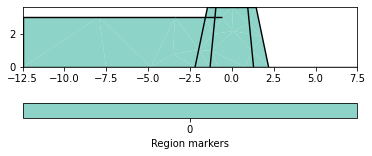

In [8]:
# create line of points on B/C height and connect them
xBC = [-xCDtop, -xBCtop, 0, xBCtop, xCDtop]
nBC = [plc.createNode([xx, hBC]) for xx in xBC]
for i in range(len(nBC)-1):
    plc.createEdge(nBC[i], nBC[i+1], 1)
# connect points from both lines by vertical lines
plc.createEdge(nBot[2], nWTC, 1)  # interface between D and C
plc.createEdge(nWTC, nBC[0], 1)
plc.createEdge(nBot[3], nWTB, 1)  # interface between C and B
plc.createEdge(nWTB, nBC[1], 1)
plc.createEdge(nBot[6], nBC[3], 1)
plc.createEdge(nBot[7], nBC[4], 1)
ax, _ = pg.show(plc)

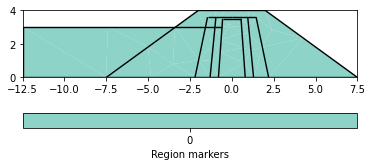

In [9]:
# create upper edges of core (A) and connect to core foot
nALeft = plc.createNode([-xABtop, hA])
nARight = plc.createNode([xABtop, hA])
plc.createEdge(nALeft, nARight, 1)
plc.createEdge(nBot[4], nWTA, 1)
plc.createEdge(nWTA, nALeft, 1)
plc.createEdge(nBot[5], nARight, 1)
# create upper crest points and connect to dam foot
nCrestLeft = plc.createNode([-wDtop / 2, hD])
nCrestRight = plc.createNode([wDtop / 2, hD])
plc.createEdge(nCrestLeft, nCrestRight, -2)
plc.createEdge(nBot[1], nWTD, 1)
plc.createEdge(nWTD, nCrestLeft, 1)
plc.createEdge(nBot[-1], nCrestRight, 1)
ax, _ = pg.show(plc)

Up to this point, we just have nodes and edges dividing the geometry into distinct parts. In order to associate different material properties, we place region markers inside of any part

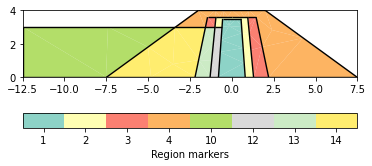

In [10]:
# add region markers to define the materials (A-D=1-4) dry and wet (+10)
plc.addRegionMarker([0.1, 0.1], 1)  # A=1
plc.addRegionMarker([xBCtop-0.01, hBC-0.01], 2)  # B above WT
plc.addRegionMarker([-xBCtop-0.1, hBC-0.1], 3)  # C above WT U.S. = 2
plc.addRegionMarker([xBCtop+0.1, hBC-0.1], 3)  # C above WT D.S. = 3
plc.addRegionMarker([xCDtop+0.1, hBC-0.1], 4)  # D above WT = 4
plc.addRegionMarker([-xD-0.1, 0.1], 10)  # water=10
plc.addRegionMarker([-xBCtop-0.01, hWT-0.01], 12)  # B below WT = 12
plc.addRegionMarker([-xBCtop-0.1, hWT-0.1], 13)  # C below WT U.S. =13
plc.addRegionMarker([-xD+0.3, 0.1], 14)  # D below WT = 14
ax, _ = pg.show(plc)
# ax.plot(pg.x(plc), pg.y(plc), 'w.');  # show nodes with white dot

In order to bring the mesh into the 3D space, we first carry out a Delaunay triangulation by calling `mt.createMesh` with a quality factor of 0. The we extrude the 2D mesh into 3D with a z vector and yield a 3D PLC. We exchange y and z so that y runs along the crest and z is upwards as usual.

In [11]:
mesh2d = pg.meshtools.createMesh(plc, quality=0)
plc3d = mt.extrudeMesh(mesh2d, [0, 20])
plc3d.swapCoordinates(1, 2)
pl, _ = pg.show(plc3d, cMap="Spectral_r", hold=True)
pl.camera_position = "yz"
pl.camera.azimuth = -90 - 10
pl.camera.elevation = 10
pl.camera.zoom(2)
pl.show()

In [12]:
# At this point we would have to insert electrodes as nodes (and possibly refinement nodes)
# for electrode in data.sensors():
#     plc3d.createNode(electrode, marker=-99
#     plc3d.createNode(electrode + pg.Pos(0, 0, 0.1), marker=-99

Finally, the mesh is created using `mt.createMesh` (calling the mesh generator TetGen) using a quality factor and a maximum tetrahedron size.

In [13]:
mesh3d = mt.createMesh(plc3d, quality=1.3, area=1)
pl, _ = pg.show(mesh3d, style="wireframe", cMap="Spectral_r")